In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/AFM/"
import numpy as np
import matplotlib.pyplot as plt
!pip install tensorflow==1.14

AFM.ipynb  data
     |████████████████████████████████| 109.2MB 38kB/s 
     |████████████████████████████████| 3.2MB 48.8MB/s 
     |████████████████████████████████| 491kB 54.4MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [ ]:
import pandas as pd
excel_file3 = '/content/drive/My Drive/AFM/data/AFM.xlsx'
data = pd.read_excel(excel_file3)
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(data, test_size=0.33)
from sklearn.preprocessing import StandardScaler
X = train_data.iloc[:,0:6].values
y= train_data.iloc[:,6].values
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = test_data.iloc[:,0:6].values
y_test = test_data.iloc[:,6].values
X_test = sc.fit_transform(X_test)
from sklearn.utils import shuffle
import numpy as np
X = np.array(X)
y = np.array(y)
X, y = shuffle(X,y)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test,y_test = shuffle(X_test,y_test)


In [ ]:
from keras.layers import * #Dense, Dropout, Conv1D,MaxPooling1D,AveragePooling1D, Flatten
from keras.models import Sequential,Model,Input
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import *#RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint,EarlyStopping
from sklearn.metrics import r2_score
from keras.regularizers import l2
#seed = 7


#np.random.seed(seed)
checkPoint = ModelCheckpoint(filepath='/content/drive/My Drive/eye_state/model/{epoch:02d}-{loss:.2f}.h5', verbose=1, save_best_only=True)
    #model=conv_pool_cnn_model
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=80,
                              verbose=1,
                              restore_best_weights=True,
                              mode='auto')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=.75, epsilon=0.001, patience=6, verbose=1)
weight_decay = 1e-12
input_shape=[6,1]
X=X.reshape(271,6,1)
X_test=X_test.reshape(134,6,1)
model_input=Input(input_shape)
def first_model(model_input):
    #x = ZeroPadding1D(2)(model_input)
    x = Conv1D(8, kernel_size=2,activation='relu',kernel_initializer='glorot_normal')(model_input)
    #x=Dropout(0.15)(x)
    x = Conv1D(16, kernel_size=2,activation='relu',kernel_initializer='glorot_normal', bias_regularizer=l2(weight_decay))(x)

    x=Flatten()(x)  
    x=Dense(8, activation='relu',kernel_initializer='glorot_normal', bias_regularizer=l2(weight_decay))(x)
    #x=Dropout(0.15)(x)
    x=Dense(16, activation='relu',kernel_initializer='glorot_normal', bias_regularizer=l2(weight_decay))(x)
    out=Dense(1,kernel_initializer='glorot_normal',bias_regularizer=l2(weight_decay),activation='linear')(x)
    model = Model(model_input, out)
    print("-- Discriminator -- ")
    model.summary()
    #model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
first_model=first_model(model_input)
from keras import optimizers
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
from keras import backend as K
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)
def percent_mean_absolute_error(y_true, y_pred):
    if not K.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    y_true = K.cast(y_true, y_pred.dtype)
    diff = K.mean(K.abs((y_pred - y_true)) / K.mean(K.clip(K.abs(y_true),
                                                           K.epsilon(),
                                                           None)))
    return 100. * K.mean(diff)
first_model.compile(loss=root_mean_squared_error, optimizer='sgd', metrics=[root_mean_squared_error]) #Adamax for better
history=first_model.fit(X,y,batch_size=6,validation_data=(X_test,y_test), shuffle=True,callbacks=[checkPoint,earlystopping,lr_reduce],epochs=400)#96&128
y_pred=first_model.predict(X_test)
r2=r2_score(y_test, y_pred)
r2


y_pred=first_model.predict(X_test)
y_pred=y_pred.reshape(134)

cc=np.corrcoef(y_test,y_pred)
cc
import scipy
#k=scipy.stats.pearsonr(y_test,y_pred)
#k
cc

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


-- Discriminator -- 
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 6, 1)              0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 5, 8)              24        
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 4, 16)             272       
_________________________________________________________________
flatten_14 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_41 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_42 (Dense)             (None, 1

array([[1.        , 0.86884135],
       [0.86884135, 1.        ]])

In [ ]:
import sklearn
mae=sklearn.metrics.mean_absolute_error(y_test, y_pred)
mae

29.893062165745974

In [ ]:
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = np.mean(x)
    my = np.mean(y)
    xm, ym = x-mx, y-my
    r_num = np.sum(tf.multiply(xm,ym))
    r_den = np.sqrt(tf.multiply(np.sum(np.square(xm)), np.sum(np.square(ym))))
    r = r_num / r_den
    r = np.maximum(np.minimum(r, 1.0), -1.0)
    return 1 - np.square(r)
cc=correlation_coefficient_loss(y_test, y_pred)
cc

TypeError: ignored

In [ ]:
y_test.shape

(134,)

In [ ]:
y_pred=first_model.predict(X)
y_pred=y_pred.reshape(271)

cc=np.corrcoef(y,y_pred)
cc
import scipy
#k=scipy.stats.pearsonr(y_test,y_pred)
#k
cc

array([[1.       , 0.7693614],
       [0.7693614, 1.       ]])

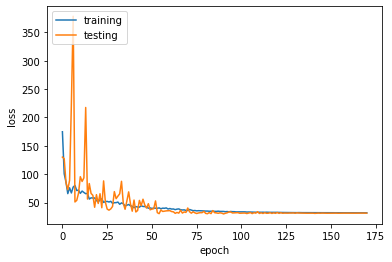

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'testing'], loc='upper left')
plt.show()
plt.savefig('/content/drive/My Drive/arif/myimage2.png', format='png', dpi=1200)

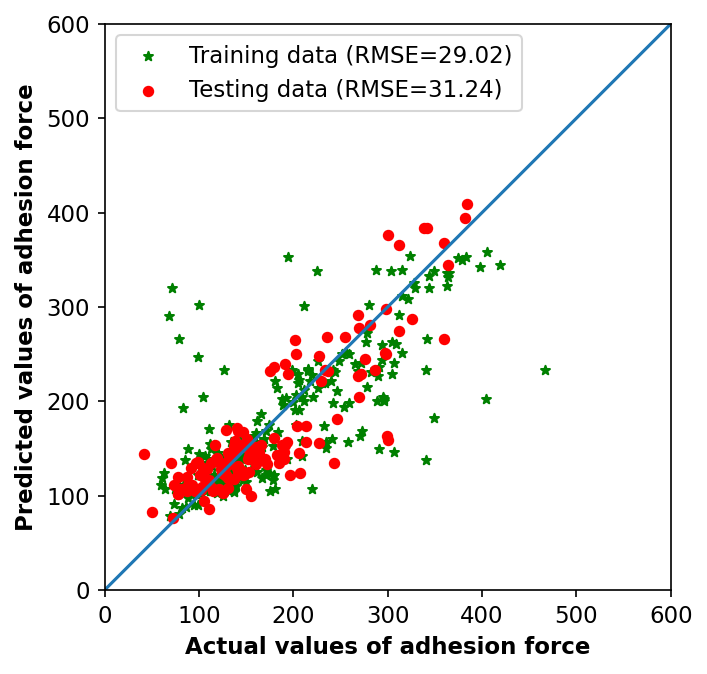

In [ ]:
train_predictions = first_model.predict(X).flatten()
test_predictions = first_model.predict(X_test).flatten()
import matplotlib
width_in_inches =5
height_in_inches =5
dots_per_inch = 150

plt.figure(
    figsize=(width_in_inches, height_in_inches),
    dpi=dots_per_inch)

SMALL_SIZE = 8
SMALL_SIZEe =11
matplotlib.rc('font', size=SMALL_SIZEe)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

a = plt.axes(aspect='equal')
plt.scatter(y, train_predictions,s=20, marker='*',color='g',label="Training data (RMSE=29.02)",)
plt.legend()
plt.scatter(y_test, test_predictions, s=20, marker='o',color='r', label='Testing data (RMSE=31.24)')
plt.legend()
plt.xlabel('Actual values of adhesion force',weight="bold")
plt.ylabel('Predicted values of adhesion force',weight="bold")
xlim = [0, 600]
plt.xlim([0, 600])
plt.ylim([0, 600])
#plt.xlim(lims)
#plt.ylim(lims)
_ = plt.plot(xlim, xlim)

In [ ]:
#!pip install eli5
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
input_shape=[6]
X=X.reshape(271,6)
X_test=X_test.reshape(134,6)
model_input=Input(input_shape)
def first_model():
    x=Dense(8, activation='relu',kernel_initializer='glorot_normal', bias_regularizer=l2(weight_decay))(model_input)
    #x=Dropout(0.15)(x)
    x=Dense(16, activation='relu',kernel_initializer='glorot_normal', bias_regularizer=l2(weight_decay))(x)
    out=Dense(1,kernel_initializer='glorot_normal',bias_regularizer=l2(weight_decay),activation='linear')(x)
    model = Model(model_input, out)
    print("-- Discriminator -- ")
    model.summary()
    model.compile(loss='mae', optimizer='sgd')
    return model

In [ ]:
X=X.reshape(271,6)
my_model = KerasRegressor(build_fn=first_model)    
my_model.fit(X,y,epochs=200, batch_size=8)

-- Discriminator -- 
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 8)                 56        
_________________________________________________________________
dense_59 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 17        
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
271/271 [==============================] - 0s 2ms/step - loss: 184.1976
Epoch 2/200
271/271 [==============================] - 0s 137us/step - loss: 183.1358
Epoch 3/200
271/271 [==============================] - 0s 130us/ste

In [ ]:
X_test=X_test.reshape(134,6)
y_test.shape

(134,)

In [ ]:
perm = PermutationImportance(my_model).fit(X_test,y_test)
eli5.show_weights(perm)

134/134 [==============================] - 0s 48us/step


Weight,Feature
45.5032 ± 8.7588,x2
30.3416 ± 3.9326,x1
13.3830 ± 5.7625,x0
8.0513 ± 1.8284,x3
0.1817 ± 0.9129,x5
-0.0739 ± 0.8034,x4
